SAR-Colombia<br>
Example scripts for Standardized Precipitation Index and Keetch-Byram Drought Index


In [69]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from standard_precip.spi import SPI
from standard_precip.utils import plot_index
import numpy as np
from geopandas.tools import sjoin
import geoplot
import rasterio

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8, 6

In [13]:
import os

path = './Temp'

# Check whether the specified path exists or not
isExist = os.path.exists(path)

if not isExist:
 
    # Create a new directory because it does not exist 
    os.makedirs(path)
    print("Temp directory created!")

In [14]:
datafile = "./Data/PTPM_CON@32010010.data"
dat = pd.read_csv(datafile,sep="|")
dat['Fecha'] = pd.to_datetime(dat['Fecha'])
dat.set_index(dat['Fecha'],inplace=True,drop=True)
dat.index.name = None
dat = dat[dat['Fecha'] >= '1990-01-01']

In [15]:
dat.head()

,Fecha,Valor
1991-06-03 07:00:00,1991-06-03 07:00:00,0.0
1991-06-04 07:00:00,1991-06-04 07:00:00,5.0
1991-06-05 07:00:00,1991-06-05 07:00:00,2.0
1991-06-06 07:00:00,1991-06-06 07:00:00,0.0
1991-06-07 07:00:00,1991-06-07 07:00:00,7.0


<AxesSubplot:xlabel='Fecha'>

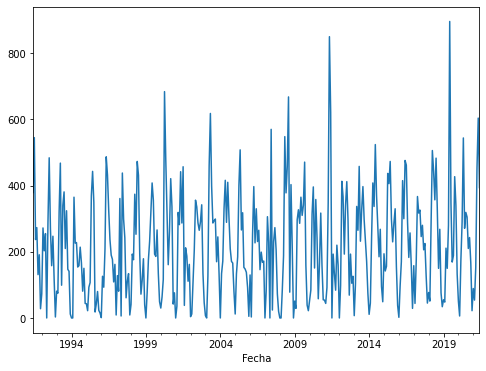

In [16]:
# Example of grouping data using 'resample'
dat.resample(rule='M', on='Fecha')['Valor'].sum().plot()

<AxesSubplot:xlabel='Fecha'>

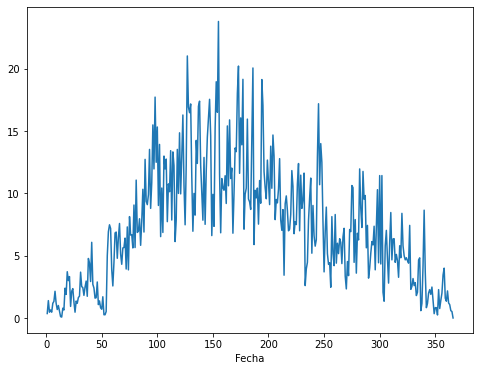

In [17]:
# Example of grouping data using 'groupby'
dat.Valor.groupby(dat.Fecha.dt.dayofyear).mean().plot()

In [18]:
# You can use 'dt' functions to create time variables for summaries
# This is an example for the Day of the Year, or Yearday
dat.Fecha.dt.dayofyear

1991-06-03 07:00:00    154
1991-06-04 07:00:00    155
1991-06-05 07:00:00    156
1991-06-06 07:00:00    157
1991-06-07 07:00:00    158
                      ... 
2021-06-26 07:00:00    177
2021-06-27 07:00:00    178
2021-06-28 07:00:00    179
2021-06-29 07:00:00    180
2021-06-30 07:00:00    181
Name: Fecha, Length: 10630, dtype: int64

In [19]:
# Determine the historical 50th and 75th percentile of daily rainfall events
dat.Valor.quantile([.5,.75])

0.50    0.0
0.75    9.0
Name: Valor, dtype: float64

In [20]:
spi = SPI()
numdays = 90   #Note: this number will be used to create a new variable in the 'dat' DataFrame
                # For example: Valor_scale_90_calculated_index
df_spi = spi.calculate(
    dat, 
    'Fecha', 
    'Valor', 
    freq="D", 
    scale=numdays, 
    fit_type="lmom", 
    dist_type="gam"
)

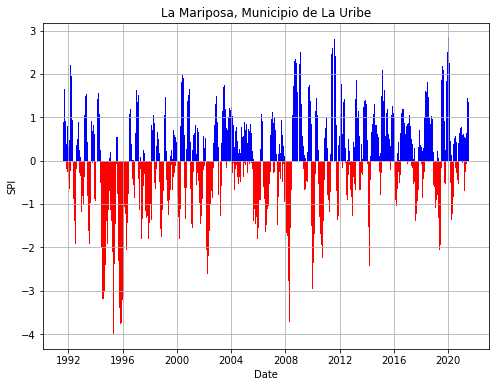

In [21]:
fig = plot_index(df_spi, 'Fecha', f'Valor_scale_{numdays}_calculated_index')
fig.gca().set_title('La Mariposa, Municipio de La Uribe')
fout = f"./Temp/LaMariposa_{numdays}Day_SPI.png"
if(fout != ""):
    plt.savefig(fout, dpi=300, bbox_inches='tight')

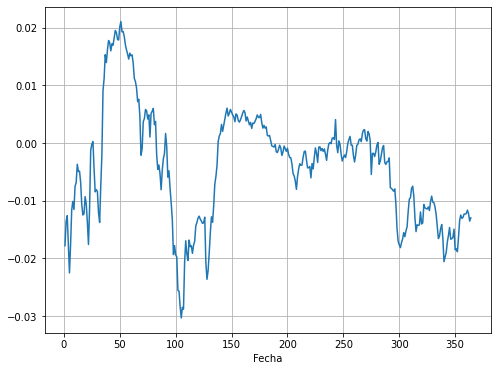

In [22]:
df_spi.Valor_scale_90_calculated_index.groupby(df_spi.Fecha.dt.dayofyear).mean()[0:364].plot()
plt.grid()
fout = f"./Temp/LaMariposa_{numdays}MeanDaily_SPI.png"
if(fout != ""):
    plt.savefig(fout, dpi=300, bbox_inches='tight')

In [231]:
# Read the MODIS data archive from FIRMS for COlombia
base = r'zip://./Data/FIRMS'
modiscofn = "%s/%s" % (base,"fire_archive_M-C61_221838.zip")
modisco = gpd.read_file(modiscofn)

<AxesSubplot:>

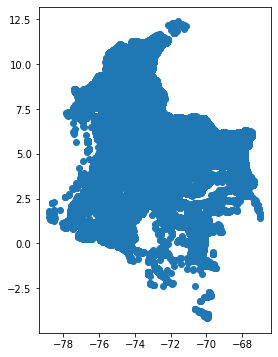

In [235]:
modisco.plot()

In [233]:
base = "zip://./Data/Base/ne_10m_admin_1_states_provinces"
fname = f"{base}/ne_10m_admin_1_states_provinces.zip"
Admin1Bnd = gpd.read_file(fname)
CO_Bnds = Admin1Bnd[Admin1Bnd.iso_a2.isin(["CO"])]
Meta_Bnd = Admin1Bnd[Admin1Bnd.name.isin(["Meta"])]

<AxesSubplot:>

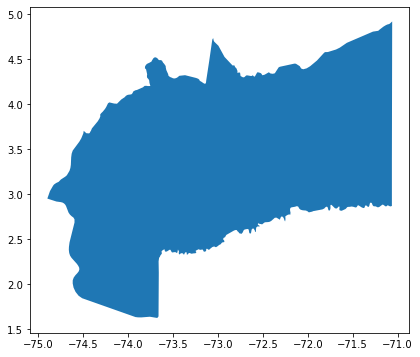

In [234]:
Meta_Bnd.plot()

In [29]:
points_polys = gpd.sjoin(modisco, CO_Bnds, how="left")
points_polys['ACQ_DATE'] = pd.to_datetime(points_polys.ACQ_DATE)
points_polys.head(10)

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,...,name_ko,name_nl,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,ne_id
0,11.0912,-72.6625,306.5,4.5,2.0,2000-11-01,1458,Terra,MODIS,26,...,라과히라 주,La Guajira,La Guajira,Guajira,Гуахира,La Guajira,La Guajira,Khu vực hành chính La Guajira,瓜希拉省,1159310189
1,11.0910,-72.6702,307.0,4.5,2.0,2000-11-01,1458,Terra,MODIS,31,...,라과히라 주,La Guajira,La Guajira,Guajira,Гуахира,La Guajira,La Guajira,Khu vực hành chính La Guajira,瓜希拉省,1159310189
2,5.3136,-68.8234,316.9,1.1,1.1,2000-11-02,0324,Terra,MODIS,94,...,비차다 주,Vichada,Vichada,Vichada,Вичада,Vichada,Vichada,Khu vực hành chính Vichada,比查达省,1159310175
3,5.3376,-68.8227,301.0,1.1,1.1,2000-11-02,0324,Terra,MODIS,29,...,비차다 주,Vichada,Vichada,Vichada,Вичада,Vichada,Vichada,Khu vực hành chính Vichada,比查达省,1159310175
4,5.3390,-68.8125,301.9,1.1,1.1,2000-11-02,0324,Terra,MODIS,40,...,비차다 주,Vichada,Vichada,Vichada,Вичада,Vichada,Vichada,Khu vực hành chính Vichada,比查达省,1159310175
5,5.6625,-69.8969,324.5,1.5,1.2,2000-11-02,1542,Terra,MODIS,80,...,비차다 주,Vichada,Vichada,Vichada,Вичада,Vichada,Vichada,Khu vực hành chính Vichada,比查达省,1159310175
6,6.4805,-69.7584,316.9,1.5,1.2,2000-11-02,1542,Terra,MODIS,73,...,아라우카 주,Arauca,Arauca,Arauca,Араука,Arauca,Arauca,Arauca,阿劳卡省,1159310159
7,5.5177,-69.8615,328.1,1.5,1.2,2000-11-02,1542,Terra,MODIS,78,...,비차다 주,Vichada,Vichada,Vichada,Вичада,Vichada,Vichada,Khu vực hành chính Vichada,比查达省,1159310175
8,5.6676,-69.7843,317.8,1.5,1.2,2000-11-02,1542,Terra,MODIS,72,...,비차다 주,Vichada,Vichada,Vichada,Вичада,Vichada,Vichada,Khu vực hành chính Vichada,比查达省,1159310175
9,5.5157,-69.8478,316.9,1.5,1.2,2000-11-02,1542,Terra,MODIS,61,...,비차다 주,Vichada,Vichada,Vichada,Вичада,Vichada,Vichada,Khu vực hành chính Vichada,比查达省,1159310175


In [35]:
MODIS_Meta = points_polys[points_polys['name'] == "Meta"]
MODIS_Bogota = points_polys[points_polys['name'] == "Bogota"]


<AxesSubplot:xlabel='ACQ_DATE'>

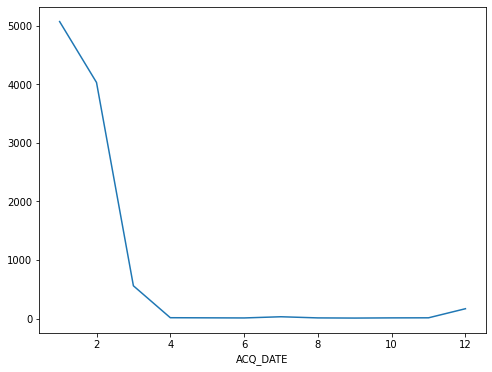

In [36]:
MODIS_Bogota.groupby(MODIS_Bogota.ACQ_DATE.dt.month).FRP.sum().plot()

C:\Users\mjolly\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mjolly\Anaconda3\lib\site-packages\seaborn\distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


<GeoAxesSubplot:>

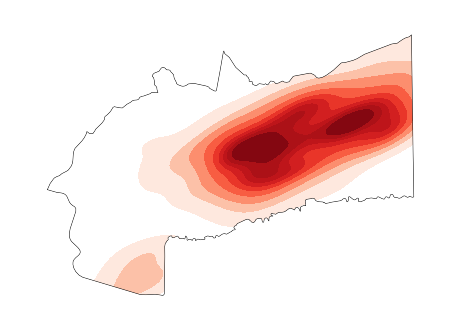

In [37]:
ax = geoplot.kdeplot(
    MODIS_Meta.head(1000), clip=Meta_Bnd,
    shade=True, cmap='Reds',
    projection=geoplot.crs.AlbersEqualArea())
geoplot.polyplot(Meta_Bnd, ax=ax, zorder=1)

C:\Users\mjolly\Anaconda3\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<AxesSubplot:xlabel='ACQ_DATE'>

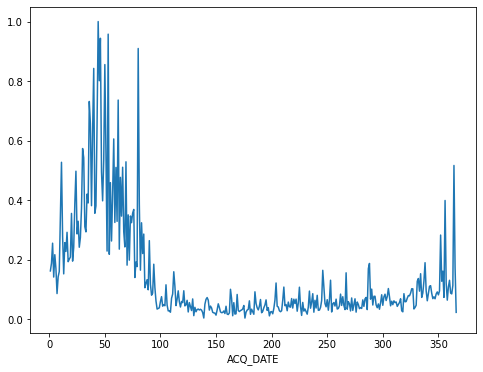

In [38]:
MODIS_Meta['FRP_Norm'] = (MODIS_Meta['FRP'] - MODIS_Meta['FRP'].min()) / (MODIS_Meta['FRP'].max() - MODIS_Meta['FRP'].min())
MODIS_Meta.groupby(MODIS_Meta.ACQ_DATE.dt.dayofyear).FRP_Norm.max().plot()

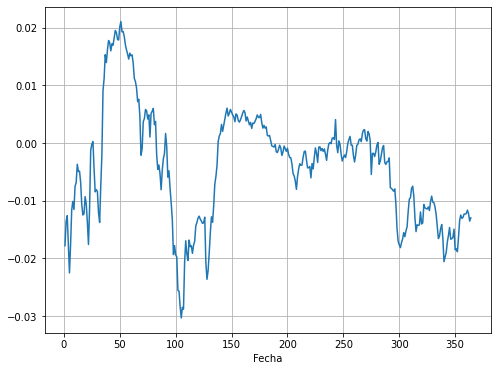

In [39]:
df_spi.Valor_scale_90_calculated_index.groupby(df_spi.Fecha.dt.dayofyear).mean()[0:364].plot()
plt.grid()
fout = f"D:/Temp/LaMariposa_{numdays}MeanDaily_SPI.png"
if(fout != ""):
    plt.savefig(fout, dpi=300, bbox_inches='tight')

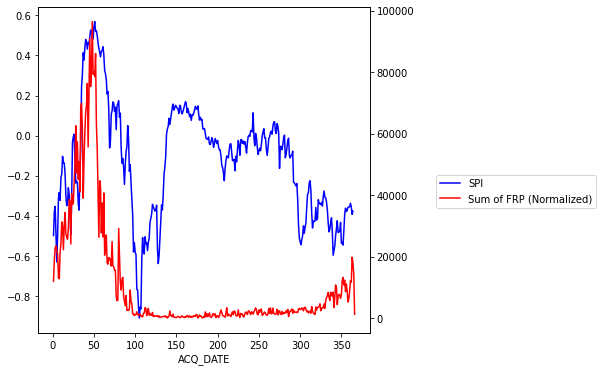

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

fig, ax = plt.subplots()
fig.subplots_adjust(right=0.7)
plt.gca().grid()
df_spi.Valor_scale_90_calculated_index.groupby(df_spi.Fecha.dt.dayofyear).sum()[0:364].plot(ax=ax, style='b-')
MODIS_Meta.groupby(MODIS_Meta.ACQ_DATE.dt.dayofyear).FRP.sum().plot(ax=ax, style='r-', secondary_y=True)
#df.C.plot(ax=ax3, style='g-')

# add legend --> take advantage of pandas providing us access
# to the line associated with the right part of the axis
ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0]],\
           ['SPI','Sum of FRP (Normalized)'], bbox_to_anchor=(1.7, 0.5))
fout = f"./Temp/LaMariposa_{numdays}Mean_SPIandFRPSum_Compare.png"
if(fout != ""):
    plt.savefig(fout, dpi=300, bbox_inches='tight')

In [126]:
# New data file with precipitation and temperature
datafile = "./Data/estacion1_35035020.csv"
dat = pd.read_csv(datafile) #,sep="|")
dat['Fecha'] = pd.to_datetime(dat['Fecha'])
dat.set_index(dat['Fecha'],inplace=True,drop=True)
dat.index.name = None
dat = dat[dat['Fecha'] >= '1990-01-01']


<AxesSubplot:>

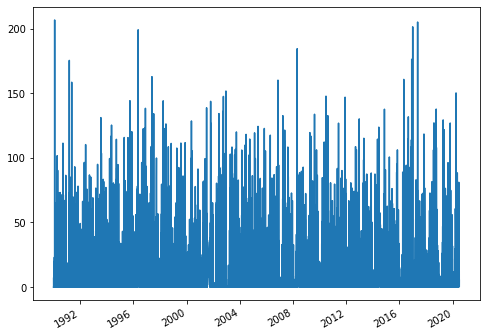

In [127]:
dat['Precipitacion'].plot()

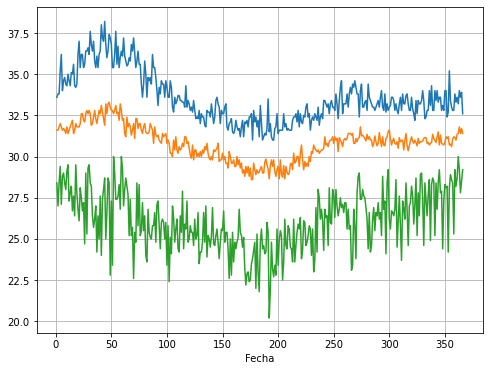

In [43]:
ax = dat.Temperatura.groupby(dat.Fecha.dt.dayofyear).max().plot()
dat.Temperatura.groupby(dat.Fecha.dt.dayofyear).median().plot(ax=ax)
dat.Temperatura.groupby(dat.Fecha.dt.dayofyear).min().plot(ax=ax)
plt.grid()

<AxesSubplot:xlabel='Fecha'>

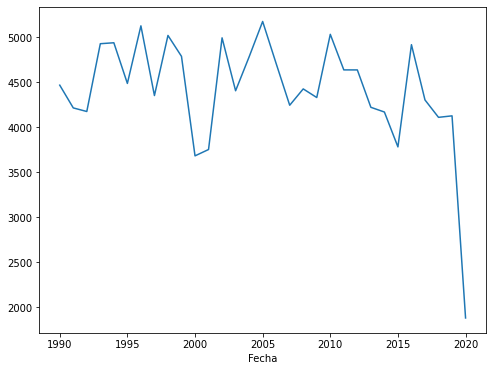

In [44]:
dat.Precipitacion.groupby(dat.Fecha.dt.year).sum().plot()

In [45]:
# Keetch-Byram Drought Index Calculator
# Author: W. Matt Jolly, USFS, RMRS, Missoula Fire Sciences Laboratory
#         Email: william.jolly@usda.gov
# Reference: Keetch, J. J., and G. M. Byram, 1968: A drought index for 
#             forest fire control.USDA Forest Service Research Paper, SE-38, 1-32.
import math
class KBDI:
    yKBDI = 100  # Yesterday's KBDI value
    KBDI = 100   # Final KBDI value
    fAvgPrecip = 15  # Mean annual precipitation (inches)
    CummPrecip = 0   # Cumulative precipitation (inches)
   
    def __init__(self,fAvgPrecipIn):
        self.fAvgPrecip = fAvgPrecipIn
       
    def Calc (self,fPrecipAmt, iMaxTemp):
            net = 0
            idq = 0
            pptnet = 0.00
            xkbdi = 0.00
            xtemp = 0.00

            KBDI = int(self.yKBDI)
            if(fPrecipAmt == 0.0):
                self.CummPrecip = 0
            else:
                if(self.CummPrecip > 0.20):
                    pptnet = fPrecipAmt
                    self.CummPrecip = self.CummPrecip + fPrecipAmt
                else:
                    self.CummPrecip = self.CummPrecip + fPrecipAmt
                    if(self.CummPrecip > 0.20):
                        pptnet = self.CummPrecip - 0.20

            net = (100.0 * pptnet) + 0.0005

            net = KBDI - net

            if net > 0:
                KBDI = round(net,0)
            else:
                KBDI = 0
            if(iMaxTemp > 50):
                idq = (800.0 - KBDI) * (0.9679 * math.exp(0.0486 * iMaxTemp) - 8.299) * 0.001 / (1.0 + 10.88 * math.exp(-0.04409 * self.fAvgPrecip)) + 0.5
            self.KBDI = int(KBDI + idq)
            self.yKBDI = self.KBDI
            return self.KBDI


In [46]:
# Calculate the mean annual precipitation in inches
mean_annual_precip = dat.Precipitacion.groupby(dat.Fecha.dt.year).sum().mean() / 25.4

In [47]:
mean_annual_precip

173.66687833375664

In [48]:
dat['KBDI'] = 100
kbdi = KBDI(mean_annual_precip)
for index, row in dat.iterrows():
    kbdi_diario = kbdi.Calc(row['Precipitacion'] / 25.4,(row['Temperatura'] * 9/5) + 32)
    dat.at[index,'KBDI'] = kbdi_diario

<AxesSubplot:>

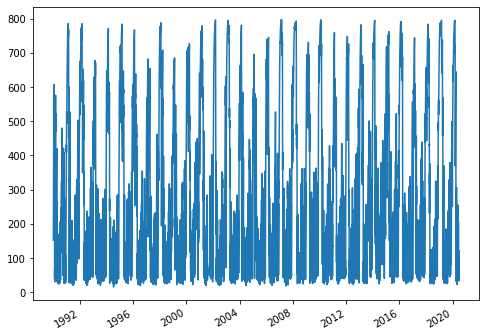

In [49]:
dat.KBDI.plot()

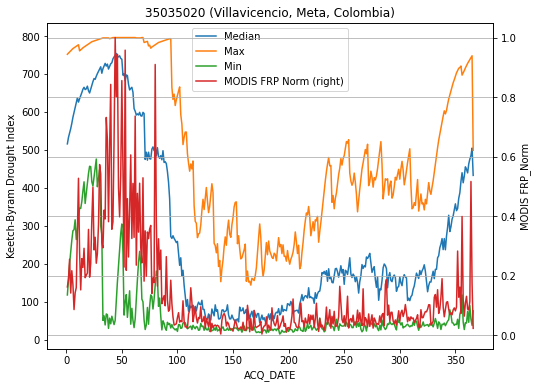

In [50]:
statid = "35035020 (Villavicencio, Meta, Colombia)"
ax = dat.KBDI.groupby(dat.Fecha.dt.dayofyear).median().plot(title=statid,legend=True,label="Median")
dat.KBDI.groupby(dat.Fecha.dt.dayofyear).max().plot(ax=ax,legend=True,label="Max")
dat.KBDI.groupby(dat.Fecha.dt.dayofyear).min().plot(ax=ax,legend=True,label="Min")
plt.gca().set_ylabel("Keetch-Byram Drought Index")
MODIS_Meta.groupby(MODIS_Meta.ACQ_DATE.dt.dayofyear).FRP_Norm.max().plot(ax=ax,secondary_y=True,legend=True,label='MODIS FRP Norm')
plt.gca().set_ylabel("MODIS FRP_Norm")

plt.grid()
fout = f"D:/Temp/{statid}_MeanDailyKBDI.png"
if(fout != ""):
    plt.savefig(fout, dpi=300, bbox_inches='tight')

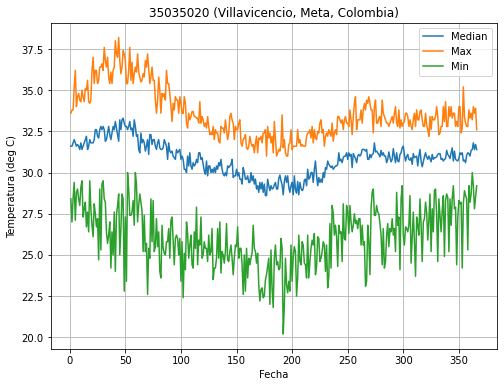

In [52]:
statid = "35035020 (Villavicencio, Meta, Colombia)"
ax = dat.Temperatura.groupby(dat.Fecha.dt.dayofyear).median().plot(title=statid,legend=True,label="Median")
dat.Temperatura.groupby(dat.Fecha.dt.dayofyear).max().plot(ax=ax,legend=True,label="Max")
dat.Temperatura.groupby(dat.Fecha.dt.dayofyear).min().plot(ax=ax,legend=True,label="Min")
plt.gca().set_ylabel("Temperatura (deg C)")
#MODIS_Meta.groupby(MODIS_Meta.ACQ_DATE.dt.dayofyear).FRP_Norm.max().plot(ax=ax,secondary_y=True,legend=True,label='MODIS FRP Norm')
#plt.gca().set_ylabel("MODIS FRP_Norm")

plt.grid()
fout = f"./Temp/{statid}_MeanDailyTemp.png"
if(fout != ""):
    plt.savefig(fout, dpi=300, bbox_inches='tight')

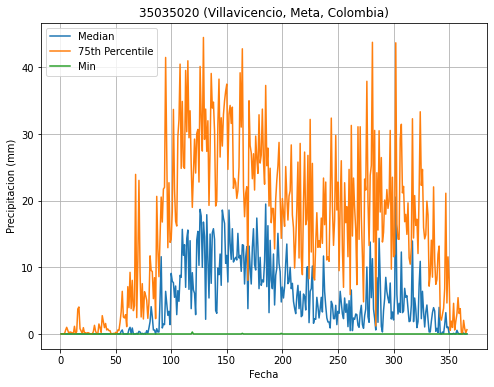

In [54]:
statid = "35035020 (Villavicencio, Meta, Colombia)"
ax = dat.Precipitacion.groupby(dat.Fecha.dt.dayofyear).median().plot(title=statid,legend=True,label="Median")
dat.Precipitacion.groupby(dat.Fecha.dt.dayofyear).quantile(0.75).plot(ax=ax,legend=True,label="75th Percentile")
dat.Precipitacion.groupby(dat.Fecha.dt.dayofyear).min().plot(ax=ax,legend=True,label="Min")
plt.gca().set_ylabel("Precipitacion (mm)")
plt.grid()
fout = f"./Temp/{statid}_MeanDailyPrecip.png"
if(fout != ""):
    plt.savefig(fout, dpi=300, bbox_inches='tight')

<AxesSubplot:xlabel='Fecha'>

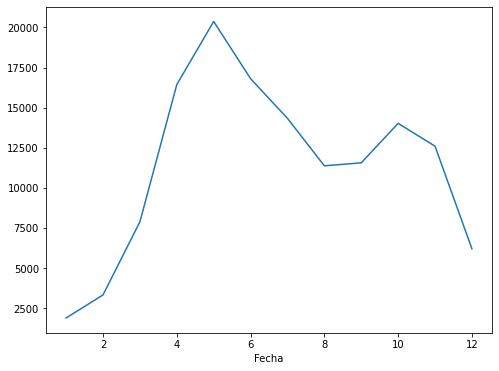

In [237]:
dat.Precipitacion.groupby(dat.Fecha.dt.month).sum().plot()

In [ ]:
spi = SPI()
numdays = 180
df_spi = spi.calculate(
    dat, 
    'Fecha', 
    'Precipitacion', 
    freq="D", 
    scale=numdays, 
    fit_type="lmom", 
    dist_type="gam"
)

In [ ]:
fig = plot_index(df_spi, 'Fecha', f'Precipitacion_scale_{numdays}_calculated_index')
fig.gca().set_title(statid)
fout = f"./Temp/{statid}_{numdays}Day_SPI.png"
if(fout != ""):
    plt.savefig(fout, dpi=300, bbox_inches='tight')

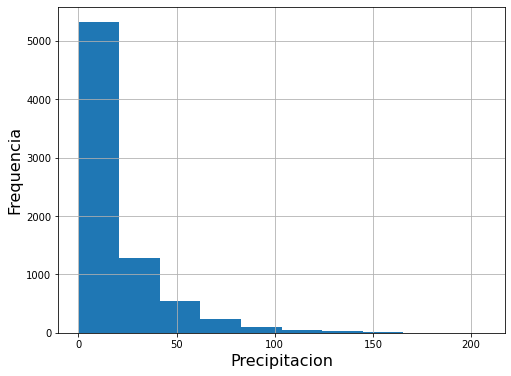

In [55]:
# Plot a histogram
dat.Precipitacion[dat.Precipitacion > 0].plot.hist()
plt.gca().set_xlabel("Precipitacion",fontsize=16)
plt.gca().set_ylabel("Frequencia",fontsize=16)
plt.grid()

In [56]:
import xarray as xr
import rioxarray as rio
import os.path
from os import path
from datetime import date, datetime,timedelta
from dateutil.relativedelta import relativedelta


In [60]:
start_date = date(2020, 1, 1)
end_date = date(2020, 12, 31)

#delta = timedelta(months=+1)
delta = relativedelta(months=1)
ds = xr.Dataset()
i = 0
while start_date <= end_date:
    strdate = int(start_date.strftime("%m"))
    file_name = 'D:/Data/Climate/wc2.1_2.5m_prec/wc2.1_2.5m_prec_%02d.tif' % (strdate)
    dt64 = np.datetime64(start_date)
    print(file_name)
    
    print(start_date)
    wc_precip = xr.open_rasterio(file_name)
    wc_precip =  wc_precip.rename({"y":"latitude","x":"longitude"})
    #wc_precip = wc_precip.assign_coords(longitude=(((senamhi_fwi0.longitude + 180) % 360) - 180)).sortby('longitude')
    dat = xr.Dataset({"time": dt64,"tp":wc_precip})
    dat = dat.drop('band')
    dat = dat.assign_coords({"time": dat.time})
    dat = dat.rio.clip(CO_Bnds.geometry, CO_Bnds.crs, drop=True)
    if i == 0:
        ds = dat
    else:
        ds = xr.concat([ds,dat],dim='time')
    i += 1
    start_date = start_date + delta


D:/Data/Climate/wc2.1_2.5m_prec/wc2.1_2.5m_prec_01.tif
2020-01-01
D:/Data/Climate/wc2.1_2.5m_prec/wc2.1_2.5m_prec_02.tif
2020-02-01
D:/Data/Climate/wc2.1_2.5m_prec/wc2.1_2.5m_prec_03.tif
2020-03-01
D:/Data/Climate/wc2.1_2.5m_prec/wc2.1_2.5m_prec_04.tif
2020-04-01
D:/Data/Climate/wc2.1_2.5m_prec/wc2.1_2.5m_prec_05.tif
2020-05-01
D:/Data/Climate/wc2.1_2.5m_prec/wc2.1_2.5m_prec_06.tif
2020-06-01
D:/Data/Climate/wc2.1_2.5m_prec/wc2.1_2.5m_prec_07.tif
2020-07-01
D:/Data/Climate/wc2.1_2.5m_prec/wc2.1_2.5m_prec_08.tif
2020-08-01
D:/Data/Climate/wc2.1_2.5m_prec/wc2.1_2.5m_prec_09.tif
2020-09-01
D:/Data/Climate/wc2.1_2.5m_prec/wc2.1_2.5m_prec_10.tif
2020-10-01
D:/Data/Climate/wc2.1_2.5m_prec/wc2.1_2.5m_prec_11.tif
2020-11-01
D:/Data/Climate/wc2.1_2.5m_prec/wc2.1_2.5m_prec_12.tif
2020-12-01


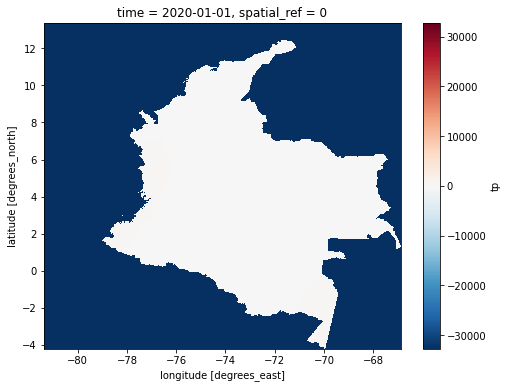

In [239]:
ds.tp[0].plot()

In [87]:
wc_precip.attrs["transform"]
from affine import Affine
transform = Affine(*wc_precip.attrs["transform"])
transform

Affine(0.041666666666666664, 0.0, -180.0,
       0.0, -0.041666666666666664, 90.0)

In [95]:
CO_Bnd = CO_Bnds.dissolve(by='iso_a2')

In [ ]:
ShapeMask = rasterio.features.geometry_mask(sf.iloc[0],
                                      out_shape=(len(ndvi.y), len(ndvi.x)),
                                      transform=ndvi.geobox.transform,
                                      invert=True)
ShapeMask = xr.DataArray(ShapeMask , dims=("y", "x"))

# Then apply the mask
NDVImasked = ndvi.where(ShapeMask == True)

<AxesSubplot:>

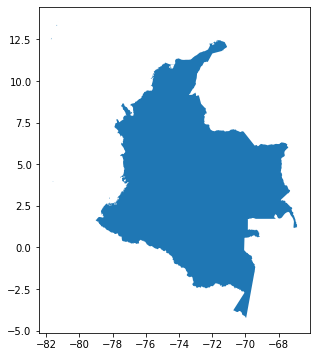

In [106]:
CO_Bnd.plot()

In [111]:
CO_Bnd.geometry

iso_a2
CO    MULTIPOLYGON (((-81.61172 3.95897, -81.61531 3...
Name: geometry, dtype: geometry

In [118]:
ShapeMask = rasterio.features.geometry_mask(CO_Bnd.iloc[0]['geometry'],out_shape=(len(ds.latitude), len(ds.longitude)),
                                      transform=transform)
ShapeMask = xr.DataArray(ShapeMask , dims=("latitude", "longitude"))

# Then apply the mask
NDVImasked = ds.where(ShapeMask == True)

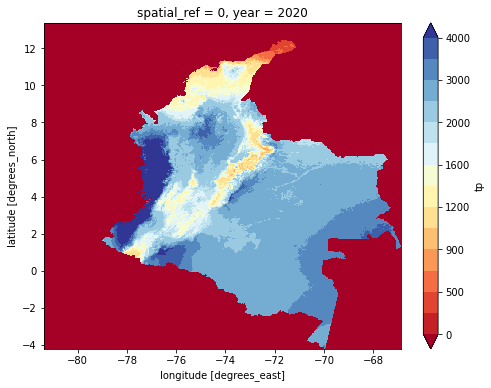

In [242]:
ds.tp.groupby(ds.time.dt.year).sum().plot(levels=[0,300,500,700,900,1000,1200,1400,1600,1800,2000,2500,3000,3500,4000],cmap='RdYlBu')

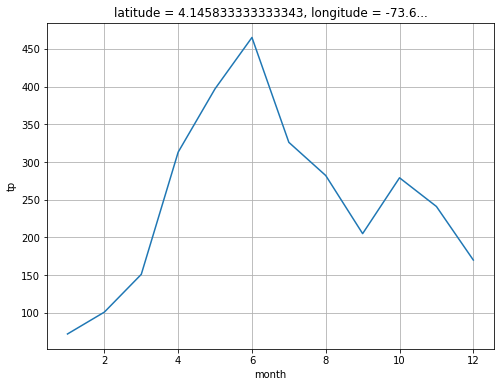

In [243]:
# Villavicencio
#-73.618 & 4.162
#ds.sel(latitude=4.162,longitude=-73.618,method='nearest').groupby(ds.time.dt.month).tp.plot()
ds.tp.sel(latitude=4.162,longitude=-73.618,method='nearest').groupby(ds.time.dt.month).mean().plot()
plt.grid()

In [132]:
np.unique(dat.Fecha.dt.year)

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [152]:
t = ds.tp.sel(latitude=4.162,longitude=-73.618,method='nearest')

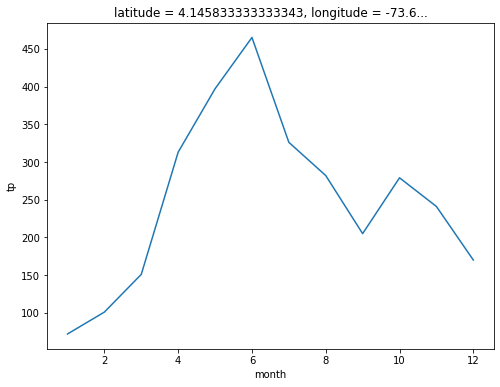

In [159]:
ax = t.groupby(ds.time.dt.month).sum().plot()
print(ax)

AxesSubplot(0.125,0.125;0.775x0.755)


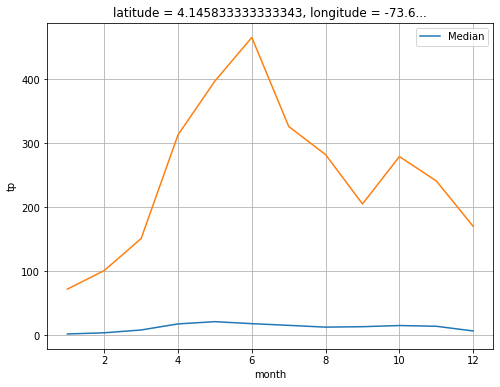

In [160]:
statid = "35035020 (Villavicencio, Meta, Colombia)"
ax = dat.Precipitacion.groupby(dat.Fecha.dt.month).mean().plot(title=statid,legend=True,label="Median")
print(ax)
#dat.Precipitacion.groupby(dat.Fecha.dt.dayofyear).quantile(0.75).plot(ax=ax,legend=True,label="75th Percentile")
#dat.Precipitacion.groupby(dat.Fecha.dt.dayofyear).min().plot(ax=ax,legend=True,label="Min")
#plt.gca().set_ylabel("Precipitacion (mm)")

ax2 = t.groupby(ds.time.dt.month).mean().plot(ax=ax)

plt.grid()
#fout = f"./Temp/{statid}_MeanDailyPrecip.png"
#if(fout != ""):
#    plt.savefig(fout, daxpi=300, bbox_inches='tight')

In [161]:
import regionmask

In [168]:
import cartopy.crs as ccrs
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch

import regionmask

regionmask.__version__

'0.7.0'

In [169]:
file = pooch.retrieve(
    "https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip", None
)

continents = gp.read_file("zip://" + file)

display(continents)

SHA256 hash of downloaded file: af0ba524a62ad31deee92a9700fc572088c2b93a39ba66f320677dd8dacaaaaf
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


,CONTINENT,geometry
0,Asia,"MULTIPOLYGON (((93.27554 80.26361, 93.31304 80..."
1,North America,"MULTIPOLYGON (((-25.28167 71.39166, -25.32889 ..."
2,Europe,"MULTIPOLYGON (((58.06138 81.68776, 57.98055 81..."
3,Africa,"MULTIPOLYGON (((0.69465 5.77337, 0.66667 5.803..."
4,South America,"MULTIPOLYGON (((-81.71306 12.49028, -81.72014 ..."
5,Oceania,"MULTIPOLYGON (((-177.39334 28.18416, -177.3958..."
6,Australia,"MULTIPOLYGON (((142.27997 -10.26556, 142.21053..."
7,Antarctica,"MULTIPOLYGON (((51.80305 -46.45667, 51.72139 -..."


In [170]:
# Create a mask on an example grid
lon = np.arange(-180, 180)
lat = np.arange(-90, 90)

mask = regionmask.mask_geopandas(continents, lon, lat)

In [236]:
# Create mask on the same grid
mask = regionmask.mask_geopandas(CO_Bnds, ds.longitude, ds.latitude)

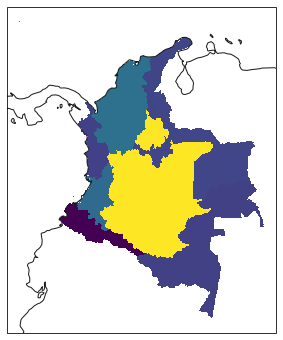

In [193]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
mask.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)

ax.coastlines(color="0.1");

In [196]:
mask

<xarray.DataArray 'region' (lat: 422, lon: 348)>
array([[2585.,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]])
Coordinates:
  * lat      (lat) float64 13.35 13.31 13.27 13.23 ... -4.104 -4.146 -4.188
  * lon      (lon) float64 -81.35 -81.31 -81.27 -81.23 ... -66.98 -66.94 -66.9

In [180]:
img = ds.tp.groupby(ds.time.dt.year).sum().compute()

In [244]:
mask = mask.rename({"lat":"latitude","lon":"longitude"})

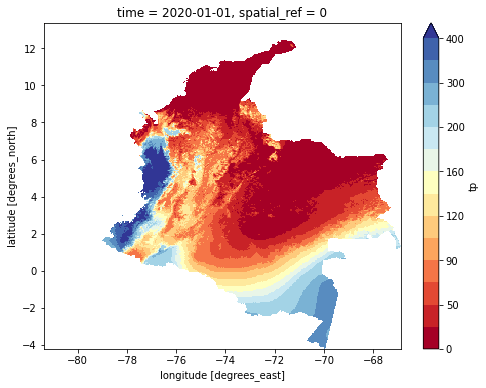

In [245]:
ds.tp[0].where(mask > 0).plot(levels=[0,30,50,70,90,100,120,140,160,180,200,250,300,350,400],cmap='RdYlBu')


MemoryError: Unable to allocate 161. GiB for an array with shape (1, 1, 422, 348, 422, 348) and data type float64

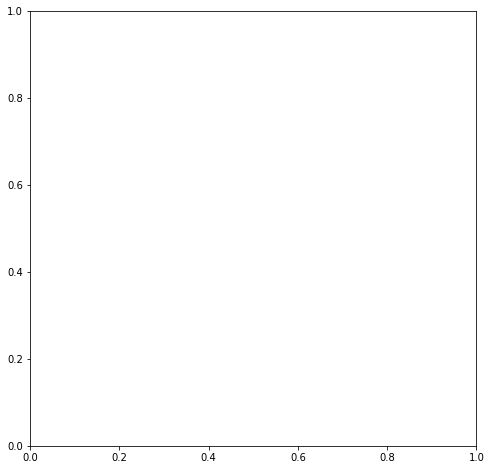

In [241]:
f, ax = plt.subplots(figsize=(8,8))

ds.tp.groupby(ds.time.dt.year).sum().where(mask > 0).plot(levels=[0,300,500,700,900,1000,1200,1400,1600,1800,2000,2500,3000,3500,4000],cmap='RdYlBu',ax=ax)
CO_Bnds.plot(color='None',
                    edgecolor='black',
                    linewidth=0.5,
                    ax=ax,
                    zorder=4)

ax.set(title="Mean annual precipitation")
ax.axis('off')



In [249]:
base = "zip://./Data/Base/ColombiaAnalysisRegions"
fname = f"{base}/Clusters_30_colombia.zip"
print(fname)
COAnalReg = gpd.read_file(fname)


zip://./Data/Base/ColombiaAnalysisRegions/Clusters_30_colombia.zip


<AxesSubplot:>

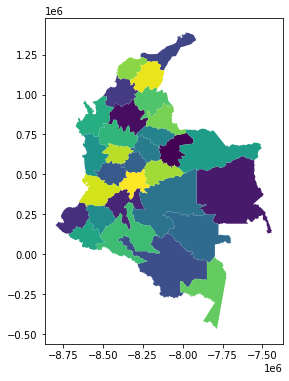

In [252]:
COAnalReg.plot(column="OBJECTID")